# 1.Importing  the libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import cv2
from PIL import Image
import seaborn as sns
import copy
import torch
from torch.utils.data import Dataset,DataLoader,Subset
import torch.optim as optim
import torchvision
from torchvision.models.detection.ssd import SSDHead,det_utils
from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights
import torchvision.transforms.functional as tf
import albumentations as A
from torchmetrics.detection import MeanAveragePrecision
import matplotlib.patches as patches
from PIL import Image

# 2.Initializing the path


In [9]:
np.random.seed(42)
torch.manual_seed(42)
image_dir="E:\\Code\\Diploma\\train"
annotation_dir="E:\\Code\\Diploma\\anotation"

# 3.Configurtion Parameters

In [6]:
classes=["background","mine"]
num_classes=len(classes)
device="cpu"
batch_size=4
epochs=50
learning_rate=3e-5
model_weights_file="model.pth"
threshold=0.25
iou_threshold=0.75
image_width = 480
image_height = 480
distribution = 0.85

## 3.5 Parse XML

In [7]:
def parse_xml(annot_path):
    # Функція для розбору XML файлу з анотаціями
    # Вхідний параметр: annot_path - шлях до XML файлу з анотаціями

    # Парсимо XML файл
    tree=ET.parse(annot_path)
    root=tree.getroot()
    
    # Отримуємо ширину та висоту зображення
    width=int(root.find("size").find("width").text)
    height=int(root.find("size").find("height").text)
    boxes=[]
    
    # Ітеруємось по всім об'єктам у кореневому елементі XML
    for obj in root.findall("object"):
        bbox=obj.find("bndbox")
        xmin=int(bbox.find("xmin").text)
        ymin=int(bbox.find("ymin").text)
        xmax=int(bbox.find("xmax").text)
        ymax=int(bbox.find("ymax").text)
        
        boxes.append([xmin,ymin,xmax,ymax])
        
    return boxes,height,width

In [10]:
ignore_image=[]
for annotation_name in os.listdir(annotation_dir):
    if annotation_name == 'desktop.ini': # Ігноруємо файл desktop.ini
        continue

    img_name=annotation_name[:-4]+".jpg"
    annotation_path=os.path.join(annotation_dir,annotation_name)

    boxes,height,width=parse_xml(annotation_path)
    
    for box in boxes:
        if box[0]<0 or box[0]>=box[2] or box[2]>width:
            # Якщо координати не в межах зображення, додаємо ім'я зображення до списку для ігнорування
            ignore_image.append(img_name)
        elif box[1]<0 or box[1]>=box[3] or box[3]>height:
            # Те саме для координат по y
            ignore_image.append(img_name)

# 4.Data Augumentation


In [11]:
train_transform=A.Compose([A.HorizontalFlip(), # Горизонтальне відображення зображення
                           A.ShiftScaleRotate(rotate_limit=15,value=0, # Зсув, масштабування та обертання
                                              border_mode=cv2.BORDER_CONSTANT),

                           A.OneOf(
                                   [A.CLAHE(), # Застосування адаптивного гістограмного вирівнювання контрасту
                                    A.RandomBrightnessContrast(), # випадкове збільшення або зменшення яскравості та контрастності
                                    A.HueSaturationValue()],p=1), # зміна відтінку, насиченості та значення кольору
                           A.GaussNoise(), # Додавання гаусівського шуму
                           A.RandomResizedCrop(height=image_height,width=image_width)], # Випадкове змінення розміру та обрізка зображення
                          bbox_params=A.BboxParams(format="pascal_voc",min_visibility=0.15, # Параметри для обробки анотаційних прямокутників
                                                   label_fields=["labels"]))
                           
val_transform=A.Compose([A.Resize(height=image_height,width=image_width)], # Змінюємо розмір зображення
                        bbox_params=A.BboxParams(format="pascal_voc",min_visibility=0.15, # Параметри для обробки анотаційних прямокутників
                                                 label_fields=["labels"]))

# 5.Custom Object Detection

In [12]:
class MineDetection(Dataset):
        # Ініціалізуємо клас
        # img_dir: шлях до директорії з зображеннями
        # annot_dir: шлях до директорії з анотаційними XML файлами
        # transform: набір трансформацій для обробки зображень та анотацій
    def __init__(self,img_dir,annot_dir,transform=None):
        super().__init__()
        self.img_dir=img_dir
        self.annot_dir=annot_dir

        # Отримуємо список зображень та ігноруємо ті, які вказані в ignore_img
        self.img_list=sorted([img for img in os.listdir(self.img_dir) 
                              if img not in ignore_image])
        
        self.transform=transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,idx):
        img_name=self.img_list[idx]
        img_path=os.path.join(self.img_dir,img_name)
        img=cv2.imread(img_path)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        annot_name=img_name[:-4]+".xml"
        annot_path=os.path.join(self.annot_dir,annot_name)
        boxes,height,width=parse_xml(annot_path)
        labels=[1]*len(boxes)
        
        if self.transform is not None:
            transformed=self.transform(image=img,bboxes=boxes,labels=labels)
            img=transformed["image"]
            boxes=transformed["bboxes"]
            labels=transformed["labels"]
        
        # Якщо в анотації відсутні прямокутники, створюємо фіктивний прямокутник та мітку
        if len(np.array(boxes).shape)!=2 or np.array(boxes).shape[-1]!=4:
            boxes=[[0.0,0.0,1.0,1.0]]
            labels=[0]
                
        # Нормалізуємо зображення та перетворюємо його в тензор
        img=img/255
        img=tf.to_tensor(img)
        img=img.to(dtype=torch.float32)

        # Підготовуємо цільову інформацію (анотації) у відповідний формат для PyTorch
        target={}
        target["boxes"]=torch.tensor(boxes,dtype=torch.float32)
        target["labels"]=torch.tensor(labels,dtype=torch.int64)
        target["id"]=torch.tensor(idx)
            
        return img,target

In [13]:
train_ds=MineDetection(image_dir,annotation_dir,train_transform)
val_ds=MineDetection(image_dir,annotation_dir,val_transform)

# 6.Splitting the dataset

In [14]:
idxs=list(range(len(train_ds)))

np.random.shuffle(idxs)
train_idx=idxs[:int(distribution * len(train_ds))]
val_idx=idxs[int(distribution * len(train_ds)):]

train_ds=Subset(train_ds,train_idx)
val_ds=Subset(val_ds,val_idx)

# 7.Data Visualization

In [15]:
def show_bbox(img, target, color=(0, 255, 0)):
    # Конвертуємо зображення та анотації у формат NumPy для відображення
    img = np.transpose(img.cpu().numpy(), (1, 2, 0))
    boxes = target["boxes"].cpu().numpy().astype("int")
    labels = target["labels"].cpu().numpy()
    img = img.copy()  # Копіюємо зображення для уникнення змін у вихідному зображенні
    
    # Проходимося по кожному прямокутнику та мітці та відображаємо їх на зображенні
    for i, box in enumerate(boxes):
        idx = int(labels[i])  # Отримуємо мітку класу для поточного прямокутника
        text = classes[idx]  # Отримуємо назву класу за його міткою

        # Малюємо прямокутник та підпис на зображенні
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 2)
        y = box[1] - 10 if box[1] - 10 > 10 else box[1] + 10  # Обчислюємо вертикальну позицію тексту
        cv2.putText(img, text, (box[0], y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)  # Додаємо текст

    return img

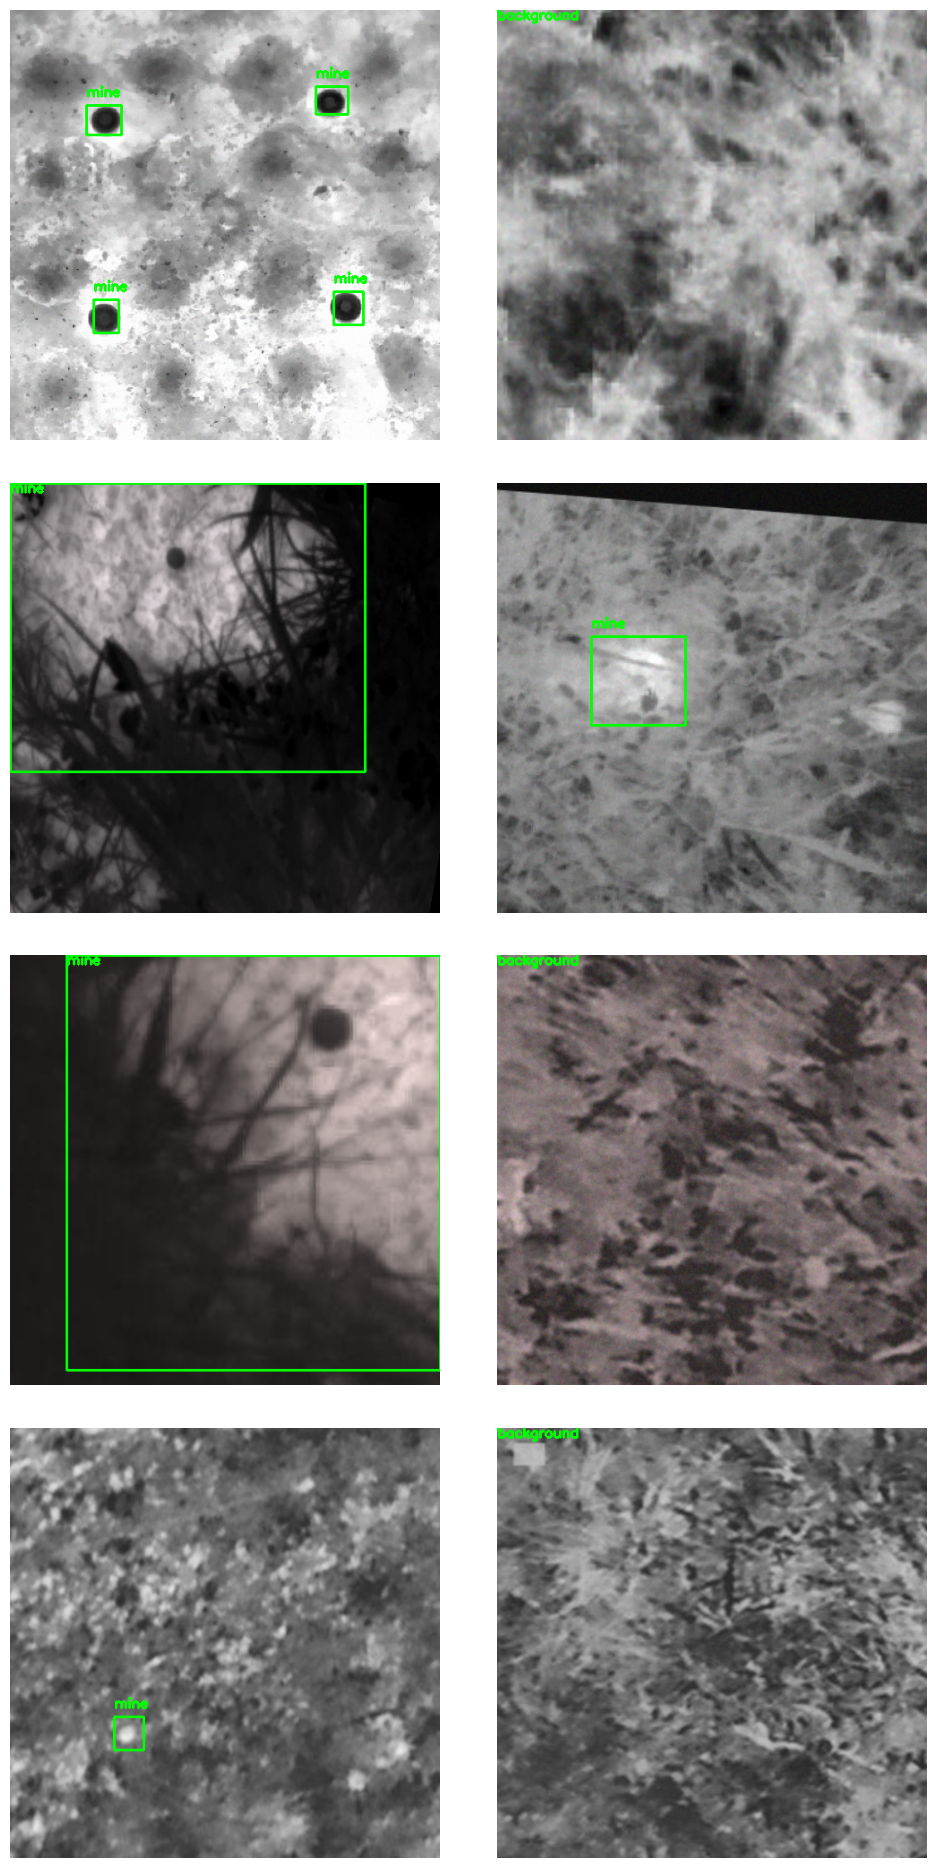

In [16]:
fig,axes=plt.subplots(4,2,figsize=(12,24))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

idxs=np.random.choice(range(len(train_ds)),8)
for i,idx in enumerate(idxs):
    img,target=train_ds[idx]
    output_img=show_bbox(img,target)
    ax[i].imshow(output_img)
    ax[i].axis("off")

# 8.Data Loader

In [17]:
def collate_fn(batch):
    # Функція для об'єднання даних з кожної партії в одну структуру даних
    # batch: список кортежів, де кожен кортеж містить зображення та його анотації
    
    # Використовуємо zip(*batch), щоб транспонувати список кортежів
    # Це дозволить отримати окремі списки для зображень та їх анотацій
    return tuple(zip(*batch))

In [18]:
# Створюємо DataLoader 
# Передаємо  Dataset
# Розмір партії даних
# Перемішуємо дані під час навантаження партій
# Кількість робочих процесів для завантаження даних
# Функція для об'єднання даних в партії
# Використовуємо pin_memory, якщо працюємо на GPU

train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                    collate_fn=collate_fn,
                    pin_memory=True if device=="cuda" else False)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count(),
                  collate_fn=collate_fn,
                  pin_memory=True if device=="cuda" else False)

# 9.Building the Model

In [19]:
# Створюємо модель SSD300 з використанням предобученої VGG16 архітектури
model=ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)

# Отримуємо кількість каналів на виході з важливих шарів моделі
in_channels=det_utils.retrieve_out_channels(model.backbone,(480,480))

# Отримуємо кількість якірних боксів на кожному рівні фічеймепа
num_anchors=model.anchor_generator.num_anchors_per_location()

# Перевизначаємо голову моделі для відповідності кількості каналів та якірних боксів
model.head=SSDHead(in_channels=in_channels, # Кількість каналів на виході з фічемепа
                   num_anchors=num_anchors, # Кількість якірних боксів на кожному рівні фічемепа
                   num_classes=num_classes # Кількість класів об'єктів
                   )

# Переміщаємо модель на вказаний пристрій
model.to(device)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

# 10. Sets up the optimizer and learning rate scheduler for training the model.

In [20]:
# Заморожуємо параметри попередньо навченої частини моделі (VGG16)
for params in model.backbone.features.parameters():
    params.requires_grad=False
    
# Отримуємо тільки ті параметри моделі, які мають вимогу для навчання
parameters=[params for params in model.parameters() if params.requires_grad]

# Ініціалізуємо оптимізатор з навчальними параметрами та вказаною швидкістю навчання
optimizer=optim.Adam(parameters,lr=learning_rate)

# Ініціалізуємо планувальник швидкості навчання для зменшення швидкості навчання в разі зупинки покращень
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,  # Використовуємо створений оптимізатор
                                                  mode='min', # Режим мінімізації: шукаємо мінімум валідаційної функції втрат
                                                  factor=0.1, # Коефіцієнт, на який зменшується швидкість навчання
                                                  patience=7, # Кількість епох, протягом яких швидкість навчання не зменшується, перш ніж вважати, що навчання зупинилося
                                                  threshold=0.0001 # Мінімальна зміна в метриці, яка вважається покращенням
                                                  )

# 11.Training

In [21]:
def get_lr(optimizer):
    # Функція для отримання поточної швидкості навчання з оптимізатора
    
    # Перебираємо параметри оптимізатора
    for params in optimizer.param_groups:
        return params["lr"]

In [73]:
loss_history = {
    "training_loss": [],
    "validation_loss": []
}


train_len=len(train_dl.dataset)
val_len=len(val_dl.dataset)

# Ініціалізуємо змінні для відстеження найкращих втрат та ваг моделі
best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

# Проводимо цикл навчання по вказаному числу епох
for epoch in range(epochs):
    
    # Ініціалізуємо втрати для тренувального та валідаційного наборів даних
    training_loss=0.0
    validation_loss=0.0
    
    # Отримуємо поточну швидкість навчання
    current_lr=get_lr(optimizer)
    
    # Переводимо модель у режим тренування 
    model.train()

    # Проходимося по тренувальному DataLoader
    for imgs,targets in train_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        
        loss_dict=model(imgs,targets)
        
        losses=sum(loss for loss in loss_dict.values())
        training_loss+=losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        
    with torch.no_grad():
        for imgs,targets in val_dl:
            imgs=[img.to(device) for img in imgs]
            targets=[{k:v.to(device) for (k,v) in t.items()} for t in targets]
            
            # Передаємо дані через модель та обчислюємо втрати
            loss_dict=model(imgs,targets)
            losses=sum(loss for loss in loss_dict.values())
            validation_loss+=losses.item()
        
    # Оновлюємо графік швидкості навчання на основі втрат валідації        
    lr_scheduler.step(validation_loss)
    # Перевіряємо, чи змінилася поточна швидкість навчання
    if current_lr!=get_lr(optimizer):
        print("Loading best Model weights")
        model.load_state_dict(best_weights)
    
    # Якщо поточні втрати валідації менші за найкращі втрати валідації
    if validation_loss<best_validation_loss:
        best_validation_loss=validation_loss
        best_weights=copy.deepcopy(model.state_dict())
        print("Updating Best Model weights")
        
    # Записуємо втрати для навчання та валідації у відповідні списки
    loss_history["training_loss"].append(training_loss/train_len)
    loss_history["validation_loss"].append(validation_loss/val_len)
            
    print(f"epoch {epoch+1} from {epochs}")
    print(f"Training Loss: {training_loss/train_len}")
    print(f"Validation_loss: {validation_loss/val_len}")
    print("\n"+"-"*50)

# Зберігаємо ваги найкращої моделі у файл
torch.save(best_weights,model_weights_file)

Updating Best Model weights
epoch 1 from 50
Training Loss: 1.744694248591784
Validation_loss: 1.3269169124556177

--------------------------------------------------
Updating Best Model weights
epoch 2 from 50
Training Loss: 1.4976024017292249
Validation_loss: 1.2464032938450942

--------------------------------------------------
Updating Best Model weights
epoch 3 from 50
Training Loss: 1.4757471168067315
Validation_loss: 1.1873244944913888

--------------------------------------------------
Updating Best Model weights
epoch 4 from 50
Training Loss: 1.3606601927421287
Validation_loss: 1.117108322955944

--------------------------------------------------
Updating Best Model weights
epoch 5 from 50
Training Loss: 1.2741195644278496
Validation_loss: 1.0536484718322754

--------------------------------------------------
epoch 6 from 50
Training Loss: 1.2168463184223133
Validation_loss: 1.0673132369547715

--------------------------------------------------
Updating Best Model weights
epoch 

# 12.Loss Visualization.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


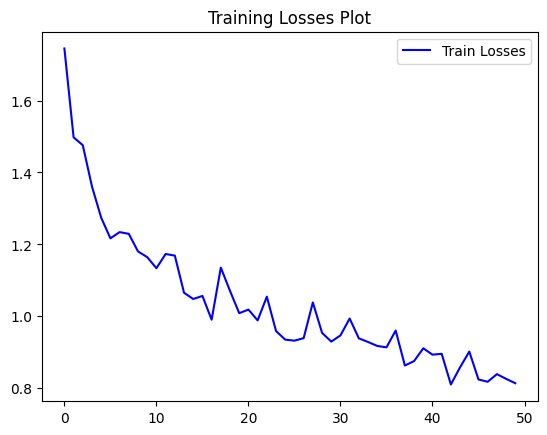

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


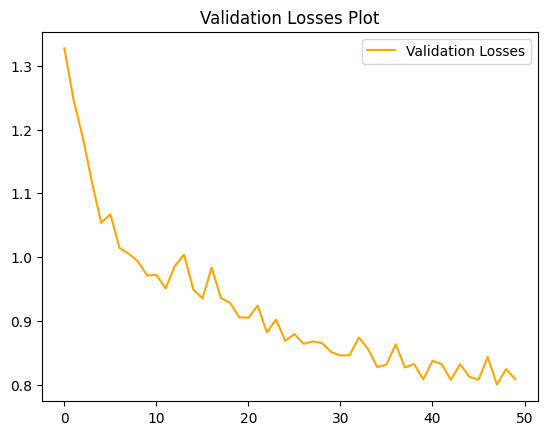

In [74]:
sns.lineplot(x=range(epochs),y=loss_history["training_loss"],color='blue', label="Train Losses");
plt.title("Training Losses Plot")
plt.show()
sns.lineplot(x=range(epochs),y=loss_history["validation_loss"], color='orange', label="Validation Losses");
plt.title("Validation Losses Plot")
plt.show()

# 13. Load a model.

In [22]:
model_weights_pth="E:\\Code\\Diploma\\model.pth"
model=ssd300_vgg16()

in_channels=det_utils.retrieve_out_channels(model.backbone,(480,480))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.load_state_dict(torch.load(model_weights_pth,map_location=device))
model.to(device)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

# 14.Preprocessing a image.

In [23]:
def preprocess_bbox(prediction):
    # Функція для обробки анотацій (областей обмеження) перед використанням
    
    processed_bbox = {}  # Ініціалізуємо словник для зберігання оброблених анотацій
    
    # Відфільтровуємо анотації (області обмеження) з низькими балами впевненості
    boxes = prediction["boxes"][prediction["scores"] >= threshold]
    scores = prediction["scores"][prediction["scores"] >= threshold]
    labels = prediction["labels"][prediction["scores"] >= threshold]
    
    # Виконуємо процедуру не максимального підтримання (NMS) для усунення дублікатів анотацій
    nms = torchvision.ops.nms(boxes, scores, iou_threshold=iou_threshold)
    
    # Зберігаємо області обмеження, бали впевненості та мітки, що пройшли фільтрацію NMS
    processed_bbox["boxes"] = boxes[nms]
    processed_bbox["scores"] = scores[nms]
    processed_bbox["labels"] = labels[nms]
    
    return processed_bbox  # Повертаємо оброблені анотації

# 15.Metrices. 

In [58]:
metric = MeanAveragePrecision(box_format='xyxy', class_metrics=True)  # Ініціалізуємо метрику середньої точності для об'єктів

metric.to(device)  # Переміщуємо метрику на пристрій

model.eval()  # Переводимо модель у режим оцінювання

with torch.no_grad():  # Відключаємо обчислення градієнтів під час оцінювання
    for imgs, targets in val_dl:  # Проходимося по валідаційному DataLoader'у
        imgs = [img.to(device) for img in imgs]  # Переміщуємо зображення на пристрій
        targets = [{k: v.to(device) for (k, v) in d.items()} for d in targets]  # Переміщуємо цільові дані на пристрій
        
        predictions = model(imgs)  # Отримуємо прогнози моделі для зображень
        
        results = []  # Ініціалізуємо список для зберігання оброблених анотацій
        
        # Проходимося по прогнозам моделі та обробляємо анотації перед використанням
        for prediction in predictions:
            results.append(preprocess_bbox(prediction))
        
        # Оновлюємо метрику з врахуванням отриманих результатів та цільових анотацій
        metric.update(results, targets)
        
# Обчислюємо значення метрики середньої точності
results = metric.compute()

In [59]:
mean_ap=results["map"].item()
mean_ap_50=results["map_50"].item()
mean_ap_75=results["map_75"].item()

print(f"Mean Average Precision[0.5:0.95:0.05] : {mean_ap:.4f}")
print(f"Mean Average Precision @ 0.5          : {mean_ap_50:.4f}")
print(f"Mean Average Precision @ 0.75         : {mean_ap_75:.4f}")

Mean Average Precision[0.5:0.95:0.05] : 0.2709
Mean Average Precision @ 0.5          : 0.6363
Mean Average Precision @ 0.75         : 0.1905


# 14.Predicting the image. 

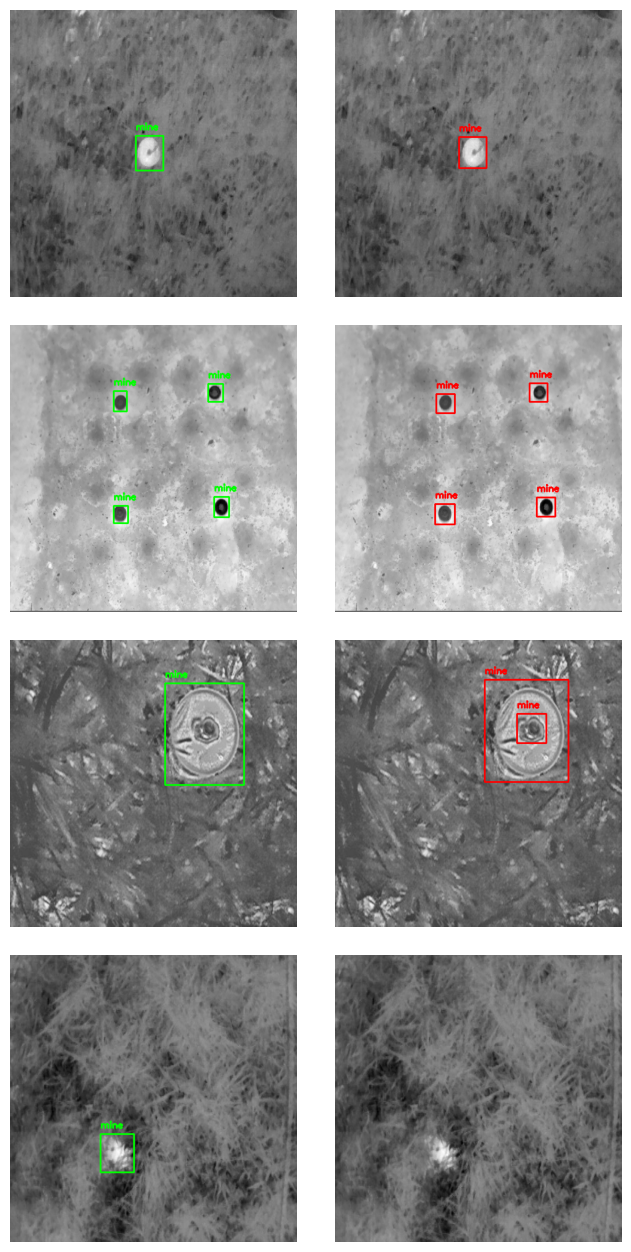

In [64]:
fig, axes = plt.subplots(4, 2, figsize=(8, 16))  # Створюємо полотно з 4 рядками та 2 стовпчиками для відображення зображень
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Налаштовуємо простір між підграфіками

i = iter(val_dl)  # Створюємо ітератор для валідаційного DataLoader'а
next(i)  # Пропускаємо перший елемент (для рівноваги)

imgs, targets = next(i)  # Отримуємо наступний набір зображень та їх цільові анотації з валідаційного DataLoader'а

model.eval()  # Переводимо модель у режим оцінювання (відключаємо dropout та batch normalization)
with torch.no_grad():  # Вимикаємо обчислення градієнтів під час оцінювання
    output = model([img.to(device) for img in imgs])  # Отримуємо прогнози моделі для зображень

# Проходимося по кожному зображенню та його прогнозам
for i, idx in enumerate(range(len(imgs))):
    img = imgs[idx]  # Отримуємо зображення
    prediction = output[idx]  # Отримуємо прогноз для даного зображення
    
    # Відображаємо зображення з реальними областями обмежень
    output_img = show_bbox(img, targets[idx], color=(0, 255, 0))  # Колір для реальних областей обмежень: зелений
    axes[i, 0].imshow(output_img)  # Відображаємо зображення на підграфіку
    axes[i, 0].axis("off")  # Вимикаємо відображення вісей координат
    
    # Відображаємо зображення з передбаченими областями обмежень
    predict = preprocess_bbox(prediction)  # Обробляємо прогноз перед відображенням
    output_img = show_bbox(img, predict, color=(255, 0, 0))  # Колір для передбачених областей обмежень: червоний
    axes[i, 1].imshow(output_img)  # Відображаємо зображення на підграфіку
    axes[i, 1].axis("off")  # Вимикаємо відображення вісей координат

plt.show()

# 15.Testing the image. 

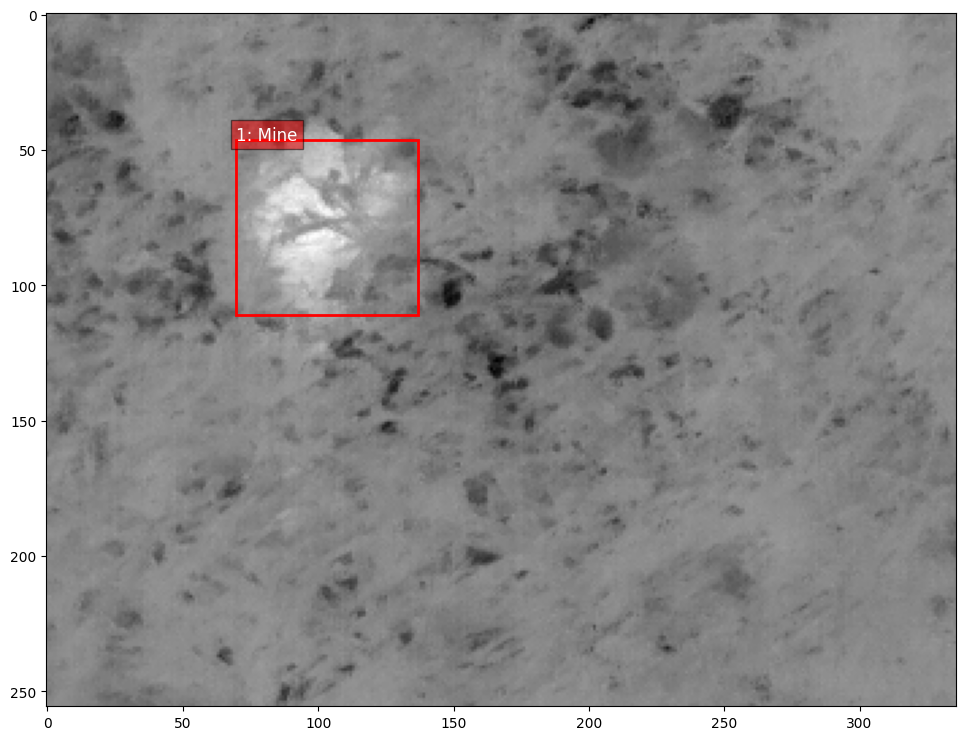

In [24]:
# Шлях до зображення
image_path = "E:\\Code\\Diploma\\Test\\Mine_1cm.jpg"

# Завантаження зображення
img = Image.open(image_path).convert("RGB")

# Передобробка зображення
img_tensor = tf.to_tensor(img)
img_tensor = img_tensor.unsqueeze(0)  # Додати розмір пакету, якщо відсутній

# Прогнозування
model.eval()
with torch.no_grad():
    img_tensor = img_tensor.to(device)  # Переміщення тензора зображення на той же пристрій, що й модель
    output = model(img_tensor)

# Отримання прогнозованих координат областей обмежень на CPU
prediction = output[0]  # Оскільки у нас лише одне зображення, беремо перший прогноз
boxes = output[0]['boxes'].cpu().numpy()
scores = output[0]['scores'].cpu().numpy()
labels = output[0]['labels'].cpu().numpy()

# Встановлення порогу впевненості
confidence_threshold = 0.5

# Фільтрація прогнозів з низькою впевненістю
high_conf_indices = scores >= confidence_threshold
boxes = boxes[high_conf_indices]
scores = scores[high_conf_indices]
labels = labels[high_conf_indices]

# Створення графіку для відображення зображення та областей обмежень
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(img)

# Додавання областей обмежень на графік
for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    width = xmax - xmin
    height = ymax - ymin
    
    # Створення прямокутного патчу
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
    
    # Додавання патчу на графік
    ax.add_patch(rect)
    
    # Додавання мітки та балу впевненості до області обмеження
    if score <= 1:
        ax.text(xmin, ymin, f'{label}: Mine', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    else:
        ax.text(xmin, ymin, f'{label}: Background', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

# Відображення графіка
plt.show()
